# Full Experiment with CatBoost Models

This notebook runs a complete experiment using all available features with both CatBoostClassifier and CatBoostRanker models.

In [8]:
import os
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from datetime import datetime

from lavka_recsys.config import Config
from lavka_recsys.experiment import Experiment, ExperimentType
from lavka_recsys.time_splitter import SplitType
from lavka_recsys.data_loader import DataLoader
from lavka_recsys.cached_feature_factory import CachedFeatureFactory
from lavka_recsys.model_factory import ModelFactory
from lavka_recsys.trainer import Trainer
from lavka_recsys.custom_logging import setup_logging

In [9]:
setup_logging()

<Logger lavka_recsys (DEBUG)>

## 1. Configuration Setup

In [10]:
# Load default configuration
config = Config()
config.load('default_config.yaml')

# Check sample_fraction configuration
sample_frac = config.get('data.sample_fraction')
print(f"sample_fraction config value: {sample_frac} (type: {type(sample_frac)})")

# Ensure it's properly None and not a string
if isinstance(sample_frac, str) and sample_frac.lower() == 'none':
    print("WARNING: sample_fraction is a string 'None', converting to proper None")
    config.set('data.sample_fraction', None)
    
# Uncomment to limit data size for faster development (comment out for full experiment)
# config.set('data.sample_fraction', 0.01)  # Use 1% sample

sample_fraction config value: None (type: <class 'NoneType'>)


In [11]:
# Set up the standard split configuration 
config.set('training.split_type', 'standard')

print(f"Using {len(config.get('features'))} features")

Using 24 features


In [12]:
# Set up experiment output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_name = f"full_experiment_{timestamp}"
results_dir = f"results/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

config.set('output.results_dir', results_dir)

## 2. Prepare Request IDs

Ensure we have request_id column for ranking models.

In [13]:
# Load data to add request_id column
data_loader = DataLoader(config)
train_df, test_df = data_loader.load_data()

print(f"Loaded {len(train_df)} training records and {len(test_df)} test records")

# Check if train_df is empty - critical issue!
if train_df.is_empty():
    print("ERROR: Training dataframe is empty! This will cause timestamp issues.")
    print("Trying to load data from test set...")
    
    # If train is empty but test has data, use test data for experiments
    if not test_df.is_empty():
        print(f"Using {len(test_df)} test records as training data")
        # Use 80% of test data for training
        split_idx = int(len(test_df) * 0.8)
        train_df = test_df.slice(0, split_idx)
        test_df = test_df.slice(split_idx, len(test_df))
        print(f"Split into {len(train_df)} training and {len(test_df)} test records")
    else:
        print("ERROR: Both train and test dataframes are empty! Cannot proceed.")
        raise ValueError("Empty dataframes - check data paths in config")

# Print detailed diagnostic information
print(f"\nDATAFRAME INFORMATION:")
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
print(f"Train columns: {train_df.columns}")

# Print timestamp info for verification
if 'timestamp' in train_df.columns:
    min_ts = train_df.select(pl.col("timestamp").min()).item()
    max_ts = train_df.select(pl.col("timestamp").max()).item()
    print(f"Timestamp range: {min_ts} to {max_ts}")
    print(f"Timestamp column type: {train_df.schema['timestamp']}")

# Fix potential timestamp issues
if 'timestamp' in train_df.columns:
    print("\nApplying timestamp fixes...")
    
    # Ensure data is sorted properly
    train_df = train_df.sort('timestamp')
    test_df = test_df.sort('timestamp')
    
    # Check and convert timestamp type if needed
    # More compatible approach that doesn't use is_temporal
    timestamp_type = str(train_df.schema['timestamp']).lower()
    is_datetime = 'datetime' in timestamp_type or 'date' in timestamp_type
    
    if not is_datetime:
        print("Converting timestamp column to datetime")
        train_df = train_df.with_columns(pl.col('timestamp').cast(pl.Datetime))
        test_df = test_df.with_columns(pl.col('timestamp').cast(pl.Datetime))
    
    # Fill any potential None values with min or max timestamps
    # This avoids the NoneType error even if they shouldn't exist
    print("Replacing any potential None values with proper timestamps")
    min_timestamp = train_df.select(pl.col('timestamp').filter(pl.col('timestamp').is_not_null()).min()).item()
    
    if min_timestamp is not None:
        train_df = train_df.with_columns(
            pl.col('timestamp').fill_null(min_timestamp)
        )
        test_df = test_df.with_columns(
            pl.col('timestamp').fill_null(min_timestamp)
        )
    else:
        print("WARNING: Could not determine a valid min timestamp!")

# Check if we already have request_id column
if 'request_id' not in train_df.columns and 'user_id' in train_df.columns:
    print("\nAdding request_id column using user_id")
    train_df = train_df.with_columns(pl.col('user_id').alias('request_id'))
    test_df = test_df.with_columns(pl.col('user_id').alias('request_id'))
else:
    print(f"\nUsing existing columns: {train_df.columns}")

# Create a modified data loader that will use our updated dataframes
class CustomDataLoader(DataLoader):
    def __init__(self, config, train_df, test_df):
        super().__init__(config)
        self.train_df = train_df
        self.test_df = test_df
        
    def load_data(self):
        return self.train_df, self.test_df

custom_data_loader = CustomDataLoader(config, train_df, test_df)

2025-04-14 19:23:54,849 - lavka_recsys.DataLoader - INFO - Loaded train data: 14954417 rows
2025-04-14 19:23:54,849 - lavka_recsys.DataLoader - INFO - Loaded test data: 565231 rows
Loaded 14954417 training records and 565231 test records

DATAFRAME INFORMATION:
Train shape: (14954417, 12), Test shape: (565231, 11)
Train columns: ['action_type', 'city_name', 'position_in_request', 'product_category', 'product_id', 'product_image', 'product_name', 'request_id', 'source_type', 'store_id', 'timestamp', 'user_id']
Timestamp range: 2022-12-31 18:46:42 to 2023-12-31 20:53:44
Timestamp column type: Datetime(time_unit='ms', time_zone=None)

Applying timestamp fixes...
Replacing any potential None values with proper timestamps

Using existing columns: ['action_type', 'city_name', 'position_in_request', 'product_category', 'product_id', 'product_image', 'product_name', 'request_id', 'source_type', 'store_id', 'timestamp', 'user_id']


## 3. CatBoost Classifier Experiment

Run an experiment with CatBoost Classifier.

In [14]:
# Configure for CatBoost classifier
classifier_config = config.copy()  # Clone the config
classifier_config.set('model.type', 'catboost')  # Set model type

# Create a specific results directory for the classifier
classifier_results_dir = f"{results_dir}/classifier"
os.makedirs(classifier_results_dir, exist_ok=True)
classifier_config.set('output.results_dir', classifier_results_dir)

# Create experiment
classifier_experiment = Experiment("catboost_classifier", classifier_config)
classifier_experiment.data_loader = custom_data_loader

# Setup and run
start_time = time.time()
classifier_experiment.setup()
classifier_results = classifier_experiment.run()
classifier_time = time.time() - start_time

# Print metrics
print(f"\nCatBoost Classifier Results (completed in {classifier_time:.2f} seconds):")
for metric, value in classifier_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

# Print feature importance
if 'feature_importance' in classifier_results:
    print("\nTop 10 Important Features:")
    top_features = sorted(classifier_results['feature_importance'].items(), 
                        key=lambda x: x[1], reverse=True)[:10]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.6f}")

2025-04-14 19:24:01,787 - lavka_recsys.CachedFeatureFactory - INFO - Using feature cache directory: results/feature_cache
2025-04-14 19:24:01,797 - lavka_recsys.Experiment(catboost_classifier_3680d2) - INFO - Created experiment directory: results/full_experiment_20250414_192354/classifier/catboost_classifier_3680d2_20250414_192401
2025-04-14 19:24:01,805 - lavka_recsys.Experiment(catboost_classifier_3680d2) - INFO - Saved configuration to results/full_experiment_20250414_192354/classifier/catboost_classifier_3680d2_config.json
2025-04-14 19:24:01,805 - lavka_recsys.Experiment(catboost_classifier_3680d2) - INFO - Setting up feature selector
2025-04-14 19:24:01,806 - lavka_recsys.FeatureSelector - INFO - Generated cache key: 43a0a9b0e9c1c093fb352ae7d50cae9d
2025-04-14 19:24:01,807 - lavka_recsys.FeatureSelector - INFO - Feature selection method: importance, n_features: 10
2025-04-14 19:24:01,809 - lavka_recsys.FeatureSelector - INFO - Cache path: /Users/almayor/Library/CloudStorage/Googl

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.1s


2025-04-14 19:27:02,572 - lavka_recsys.FeatureSelector - INFO - Feature importances: [0.0290228  0.02829745 0.03118373 0.00135358 0.0308911  0.0025976
 0.02521395 0.02136899 0.02800723 0.01570797 0.02521835 0.01508323
 0.01588627 0.00379751 0.01005034 0.01586622 0.01270894 0.01339384
 0.03819988 0.04163459 0.01118057 0.01530097 0.02821373 0.04135706
 0.0002275  0.01479499 0.0207155  0.00988737 0.00301175 0.02280178
 0.01279236 0.00749331 0.0125101  0.03881463 0.02584214 0.02079864
 0.00414795 0.01324153 0.03225121 0.02325559 0.03119302 0.00767076
 0.047693   0.001306   0.01534061 0.01251803 0.02544091 0.01668201
 0.00112579 0.00425187 0.00444912 0.02307983 0.00548925 0.00403743
 0.01492208 0.01278168 0.00386278 0.00403359]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


2025-04-14 19:27:02,681 - lavka_recsys.FeatureSelector - INFO - Selected 10 features out of 58
2025-04-14 19:27:02,682 - lavka_recsys.FeatureSelector - INFO - Removed 48 features
2025-04-14 19:27:02,682 - lavka_recsys.FeatureSelector - INFO - Removed features: {'ctr_product', 'views_day_u_p', 'month', 'std_purchase_hour', 'user_product_purchase_cross', 'product_total_interactions', 'user_total_interactions', 'cart_to_purchase_rate', 'city_unique_stores', 'store_total_interactions', 'store_unique_products', 'views_month_u_p', 'user_store_purchase_cross', 'purchases_month_u_p', 'user_total_purchases', 'interactions_month_u_p', 'store_total_views', 'product_unique_users', 'purchases_day_u_p', 'days_since_interaction_u_p', 'user_product_store_cross', 'days_since_interaction_u_s', 'city_total_interactions', 'purchases_week_u_p', 'mean_interval_days', 'most_common_purchase_day', 'session_purchases', 'avg_purchase_hour', 'day_of_week_relevance', 'city_purchase_view_ratio', 'count_purchase_u_s

## 4. CatBoost Ranker Experiment

Run an experiment with CatBoost Ranker.

In [15]:
# Configure for CatBoost ranker
ranker_config = config.copy()  # Clone the config
ranker_config.set('model.type', 'catboost_ranker')  # Set model type

# Create a specific results directory for the ranker
ranker_results_dir = f"{results_dir}/ranker"
os.makedirs(ranker_results_dir, exist_ok=True)
ranker_config.set('output.results_dir', ranker_results_dir)

# Create experiment
ranker_experiment = Experiment("catboost_ranker", ranker_config)
ranker_experiment.data_loader = custom_data_loader

# Setup and run
start_time = time.time()
ranker_experiment.setup()
ranker_results = ranker_experiment.run()
ranker_time = time.time() - start_time

# Print metrics
print(f"\nCatBoost Ranker Results (completed in {ranker_time:.2f} seconds):")
for metric, value in ranker_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

# Print feature importance
if 'feature_importance' in ranker_results:
    print("\nTop 15 Important Features:")
    top_features = sorted(ranker_results['feature_importance'].items(), 
                        key=lambda x: x[1], reverse=True)[:15]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.6f}")

2025-04-14 19:31:13,054 - lavka_recsys.CachedFeatureFactory - INFO - Using feature cache directory: results/feature_cache
2025-04-14 19:31:13,063 - lavka_recsys.Experiment(catboost_ranker_6e2461) - INFO - Created experiment directory: results/full_experiment_20250414_192354/ranker/catboost_ranker_6e2461_20250414_193113
2025-04-14 19:31:13,071 - lavka_recsys.Experiment(catboost_ranker_6e2461) - INFO - Saved configuration to results/full_experiment_20250414_192354/ranker/catboost_ranker_6e2461_config.json
2025-04-14 19:31:13,071 - lavka_recsys.Experiment(catboost_ranker_6e2461) - INFO - Setting up feature selector
2025-04-14 19:31:13,072 - lavka_recsys.FeatureSelector - INFO - Generated cache key: 43a0a9b0e9c1c093fb352ae7d50cae9d
2025-04-14 19:31:13,073 - lavka_recsys.FeatureSelector - INFO - Feature selection method: importance, n_features: 10
2025-04-14 19:31:13,075 - lavka_recsys.FeatureSelector - INFO - Cache path: /Users/almayor/Library/CloudStorage/GoogleDrive-mayorovme@gmail.com/M

## 5. Create Kaggle Submissions

In [16]:
# Create Kaggle submissions for both models
classifier_submission = classifier_experiment.create_kaggle_submission()
ranker_submission = ranker_experiment.create_kaggle_submission()

# Save submissions
classifier_submission.to_csv(f"{classifier_results_dir}/submission.csv", index=False)
ranker_submission.to_csv(f"{ranker_results_dir}/submission.csv", index=False)

print(f"Saved submissions to {classifier_results_dir}/submission.csv and {ranker_results_dir}/submission.csv")

2025-04-14 19:44:50,171 - lavka_recsys.Experiment(catboost_classifier_3680d2) - INFO - Using last trained model for Kaggle submission
2025-04-14 19:44:50,172 - lavka_recsys.Experiment(catboost_classifier_3680d2) - INFO - Generating features for Kaggle test data
2025-04-14 19:44:50,179 - lavka_recsys.CachedFeatureFactory - INFO - Generating features for 565231 records with 24 feature sets
2025-04-14 19:44:50,180 - lavka_recsys.FeatureFactory - INFO - Generating features: source_type, count_purchase_user_product, count_purchase_user_store, ctr_product, cart_to_purchase_rate, purchase_view_ratio, recency_user_product, user_stats, product_stats, store_stats, city_stats, product_temporal_patterns, recency_user_store, time_features, time_window_user_product, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, puresvd-cf, svd-cf
2025-04-14 19:45:42,175 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-04-14 19:45:4

## 6. Compare Models

In [17]:
# Gather metrics from both models for comparison
metrics_comparison = {
    'Model': ['CatBoost Classifier', 'CatBoost Ranker'],
    'Training Time (s)': [classifier_time, ranker_time]
}

# Add all metrics to the comparison
all_metrics = set(list(classifier_results['metrics'].keys()) + list(ranker_results['metrics'].keys()))
for metric in all_metrics:
    metrics_comparison[metric] = [
        classifier_results['metrics'].get(metric, float('nan')),
        ranker_results['metrics'].get(metric, float('nan'))
    ]

# Convert to DataFrame and display
metrics_df = pd.DataFrame(metrics_comparison)
print("Model Comparison:")
display(metrics_df)

# Save comparison to results directory
metrics_df.to_csv(f"{results_dir}/model_comparison.csv", index=False)

# Also save as readable markdown table
with open(f"{results_dir}/model_comparison.md", 'w') as f:
    f.write(metrics_df.to_markdown(index=False, floatfmt=".4f"))

Model Comparison:


,Model,Training Time (s),auc,ndcg@10
0,CatBoost Classifier,414.968725,0.843459,0.455186
1,CatBoost Ranker,812.030756,0.507122,0.314312


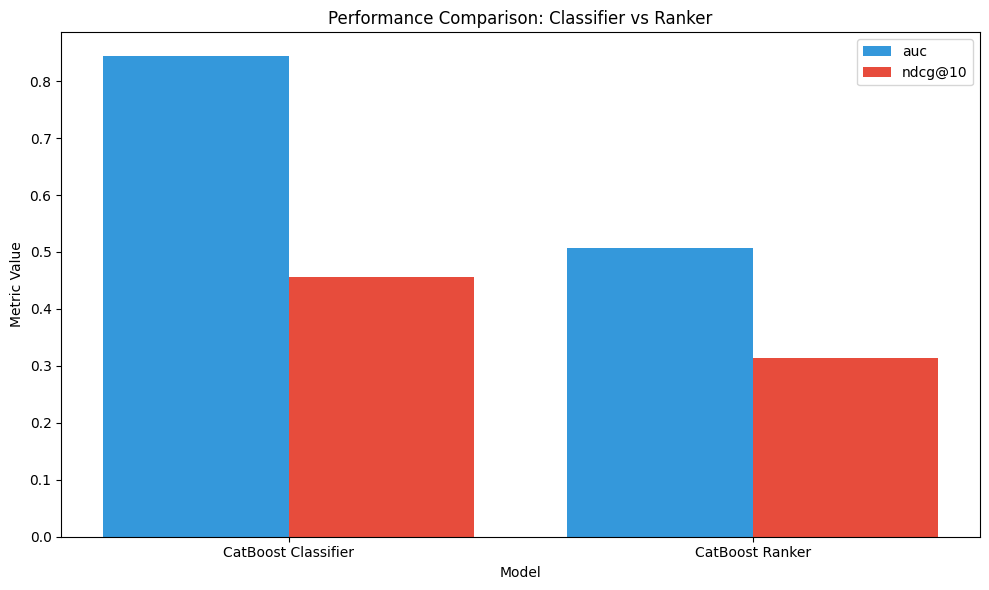

In [18]:
# Visualize metrics comparison
metrics_to_plot = [m for m in all_metrics if m in ['auc', 'ndcg@10', 'logloss']]
if metrics_to_plot:
    plt.figure(figsize=(10, 6))
    x = range(len(metrics_comparison['Model']))
    colors = ['#3498db', '#e74c3c']
    width = 0.8 / len(metrics_to_plot)
    
    for i, metric in enumerate(metrics_to_plot):
        if metric in metrics_comparison:
            plt.bar([p + width*i - width*(len(metrics_to_plot)-1)/2 for p in x], 
                    metrics_comparison[metric], 
                    width=width, 
                    label=metric,
                    color=colors[i % len(colors)])
    
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.title('Performance Comparison: Classifier vs Ranker')
    plt.xticks(x, metrics_comparison['Model'])
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f"{results_dir}/metrics_comparison.png", dpi=300)
    plt.show()

## 7. Feature Importance Comparison

Top 20 Features by Average Importance:


,Feature,Classifier Importance,Ranker Importance,Average Importance
0,day_of_week,0.430708,76.877028,38.653868
1,source_type,58.305537,3.002235,30.653886
2,hour_of_day,1.466124,13.414695,7.440410
3,purchase_view_ratio,8.873916,0.592308,4.733112
4,npmi_cf_score,8.072921,0.442717,4.257819
5,svd_cf_score,6.451163,0.414012,3.432587
6,cf_score,5.679996,0.626020,3.153008
7,city_name,2.079124,2.181367,2.130246
8,puresvd_cf_score,3.644003,0.430520,2.037261
9,product_total_views,3.010610,0.541515,1.776062


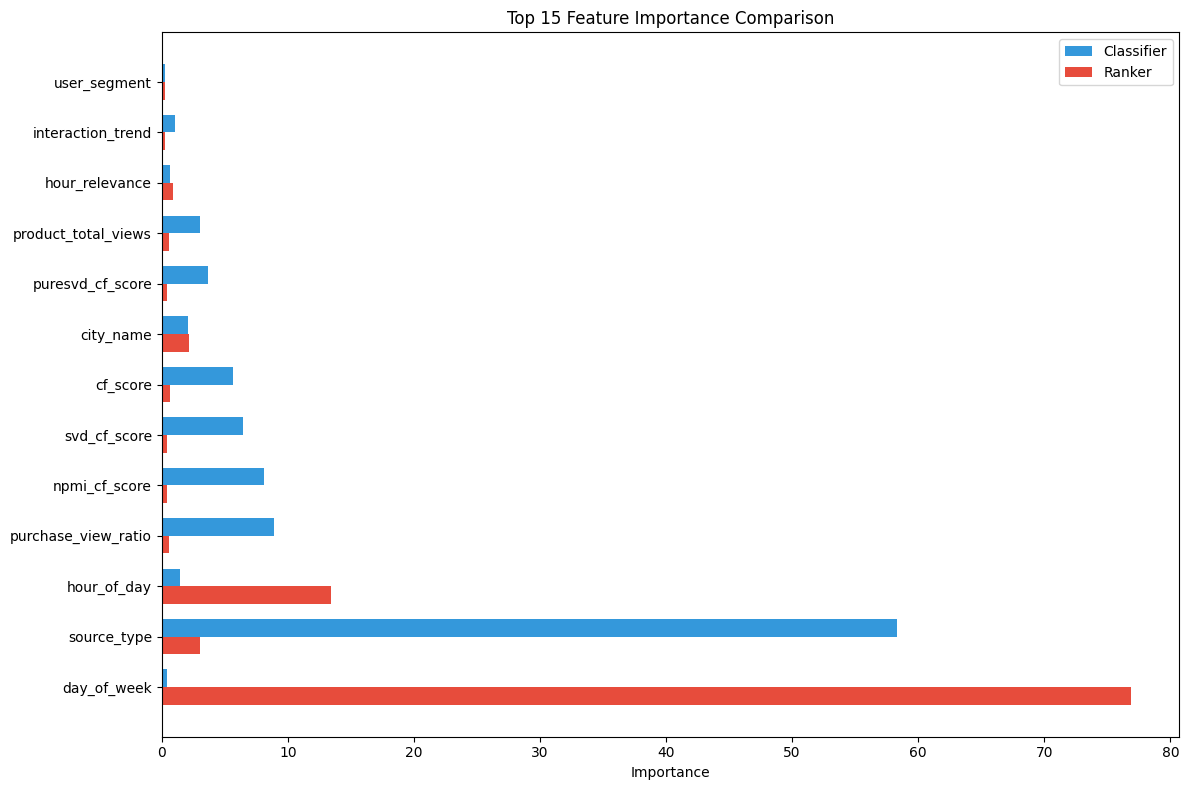

In [19]:
# Compare feature importance between models
if 'feature_importance' in classifier_results and 'feature_importance' in ranker_results:
    # Get all features from both models
    all_features = set(list(classifier_results['feature_importance'].keys()) + 
                        list(ranker_results['feature_importance'].keys()))
    
    # Create comparison dataframe
    fi_comparison = {'Feature': []}
    fi_comparison['Classifier Importance'] = []
    fi_comparison['Ranker Importance'] = []
    
    for feature in all_features:
        fi_comparison['Feature'].append(feature)
        fi_comparison['Classifier Importance'].append(
            classifier_results['feature_importance'].get(feature, 0))
        fi_comparison['Ranker Importance'].append(
            ranker_results['feature_importance'].get(feature, 0))
        
    # Convert to DataFrame and sort by average importance
    fi_df = pd.DataFrame(fi_comparison)
    fi_df['Average Importance'] = (fi_df['Classifier Importance'] + fi_df['Ranker Importance']) / 2
    fi_df = fi_df.sort_values('Average Importance', ascending=False).reset_index(drop=True)
    
    # Save to results directory
    fi_df.to_csv(f"{results_dir}/feature_importance_comparison.csv", index=False)
    
    # Display top features
    print("Top 20 Features by Average Importance:")
    display(fi_df.head(20))
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    top_n = 15
    top_features = fi_df.head(top_n)
    
    x = range(len(top_features))
    width = 0.35
    
    plt.barh([p + width/2 for p in x], top_features['Classifier Importance'], 
            height=width, label='Classifier', color='#3498db')
    plt.barh([p - width/2 for p in x], top_features['Ranker Importance'], 
            height=width, label='Ranker', color='#e74c3c')
    
    plt.yticks(x, top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importance Comparison')
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f"{results_dir}/feature_importance_comparison.png", dpi=300)
    plt.show()

## 8. Save Experiment Configuration and Results

In [20]:
# Combine all results
experiment_results = {
    'timestamp': timestamp,
    'classifier': {
        'config': classifier_config.to_dict(),
        'metrics': classifier_results['metrics'],
        'training_time': classifier_time
    },
    'ranker': {
        'config': ranker_config.to_dict(),
        'metrics': ranker_results['metrics'],
        'training_time': ranker_time
    },
    'feature_counts': len(all_features),
    'experiment_name': experiment_name
}

# Save as JSON
with open(f"{results_dir}/experiment_results.json", 'w') as f:
    json.dump(experiment_results, f, indent=2, default=str)

print(f"Experiment complete. All results saved to {results_dir}/")

Experiment complete. All results saved to results/full_experiment_20250414_192354/
